# Prediction of financial series using regression models

In [161]:
#import libraries to manipulate and visualize data 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from datetime import date
from pandas_datareader import wb
from pandas_datareader import data as web
import seaborn as sns
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')



## Period and series

Choose an asset to predict their behavior and 4 correlated series.

In [162]:
#Choose period
start = datetime(2010, 1, 1)
end = date.today()

#Choose series
serie   = 'TSLA'
serie_2 = 'AMZN'
serie_3 = 'GOOGL'
serie_4 = '^GSPC'
serie_5 = '^VIX'

#import data 
tickers = [serie,serie_2,serie_3,serie_4,serie_5]
dataset = web.DataReader(tickers, 'yahoo',start,end)['Adj Close'].dropna()


### Quick visualization

The series are scaled between 0 and 1

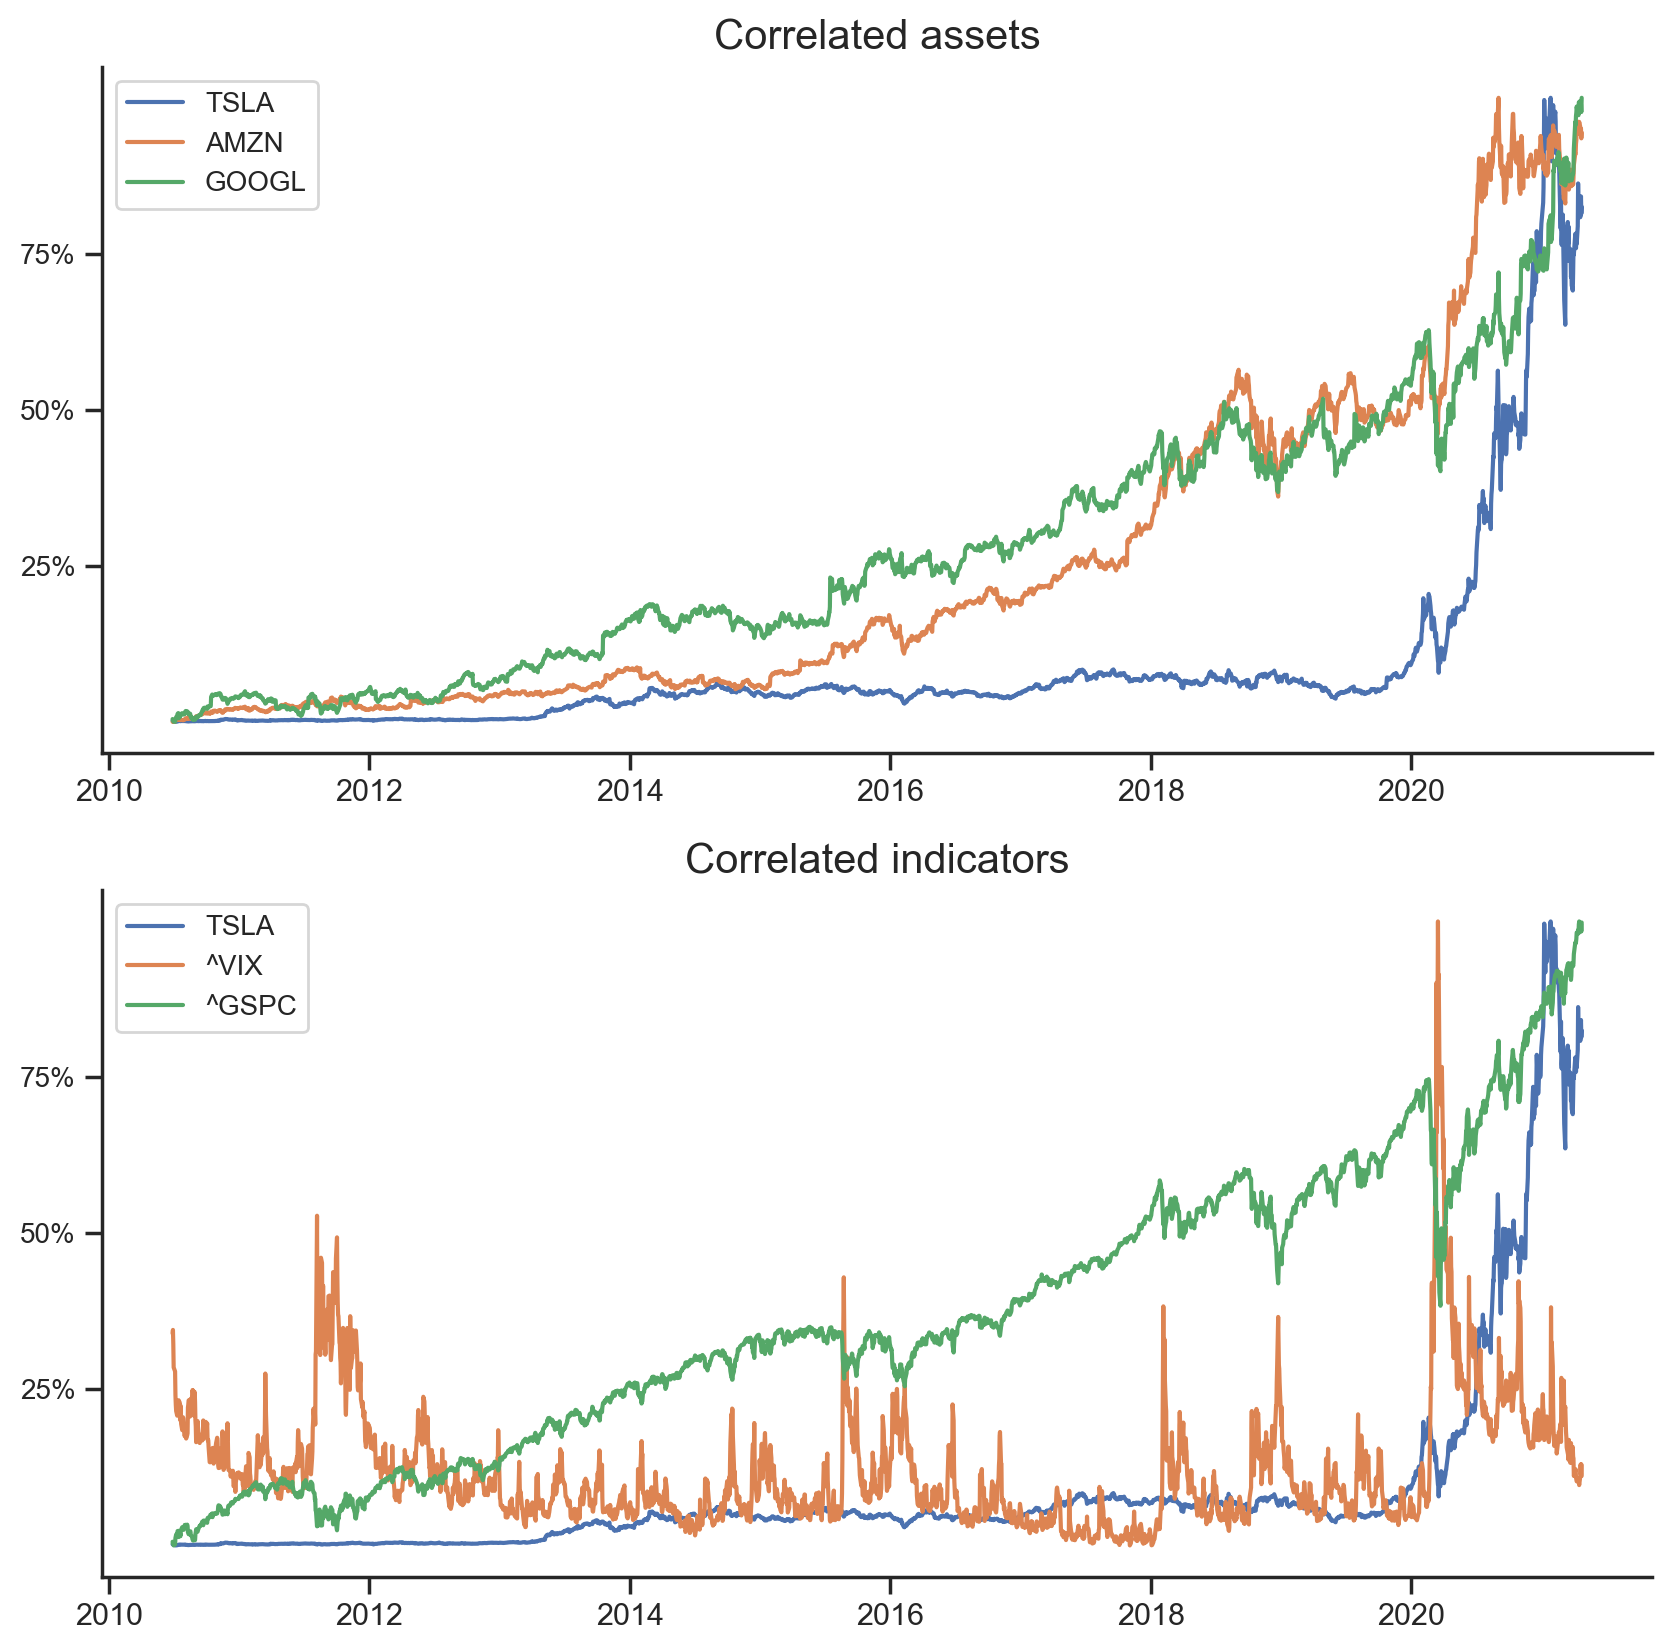

In [163]:
#scale data for visualization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_data = pd.DataFrame(scaler.fit_transform(dataset))
scaler_data.index = dataset.index
scaler_data.columns = [serie,serie_2,serie_3,serie_4,serie_5]

#Visualization 

#Figure size
plt.figure(figsize=(10, 10), dpi = 200)

#Color palette
#palette = sns.color_palette('pastel')
#sns.palplot(palette)
#sns.set_palette(palette)
sns.set_theme(style="ticks")

#Plot 1: assets
ax_1 = plt.subplot(2,1,1)
plt.title('Correlated assets',fontsize = 15)
sns.lineplot(scaler_data[serie].index,scaler_data[serie])
sns.lineplot(scaler_data[serie].index,scaler_data[serie_2])
sns.lineplot(scaler_data[serie].index,scaler_data[serie_3])
plt.ylabel('')
plt.xlabel('')
ax_1.set_yticks([0.25, 0.5, 0.75])
ax_1.set_yticklabels(['25%', '50%', '75%'],fontsize = 10)
plt.legend([serie,serie_2,serie_3],fontsize = 10)
sns.despine()

#Plot 1: indices
ax_2 = plt.subplot(2,1,2)
plt.title('Correlated indicators',fontsize = 15)
sns.lineplot(scaler_data[serie].index,scaler_data[serie])
sns.lineplot(scaler_data[serie].index,scaler_data[serie_5])
sns.lineplot(scaler_data[serie].index,scaler_data[serie_4])
plt.ylabel('')
plt.xlabel('')
ax_2.set_yticks([0.25, 0.5, 0.75])
ax_2.set_yticklabels(['25%', '50%', '75%'],fontsize = 10)
plt.legend([serie,serie_5,serie_4],fontsize = 10)
sns.despine()

plt.subplots_adjust(hspace=0.20)
 
plt.show()
plt.close()

Choose the type of observation: daily, weekly or monthly.

In [164]:
#Type of obsevation Function
def choose_period(time_period,data):
    time_period = time_period.lower()
    if time_period == 'daily':
        period = 1
    elif time_period == 'weekly':
        period = 5
    elif time_period == 'monthly':
        period = 20
    else:
        print('introduce time period: Daily, Weekly or Monthly')
    data = data.dropna().iloc[::period,:]
    return data


In [165]:
#Choose type of observation: daily,weekly or monthly
time_period = 'daily'

#Create the dataset and calculate logaritmic returns
dataset = choose_period(time_period,dataset)
r_dataset = pd.DataFrame(np.log(dataset).diff(1))

#introduce delayed series in 3, 6 and 12 periods 
lag_series = pd.concat([np.log(dataset[serie]).diff(i) for i in [3, 6,12]], axis=1)
lag_series.index = r_dataset.index
r_dataset = pd.concat([r_dataset,lag_series],axis = 1).dropna()
r_dataset.columns = [serie,serie_2,serie_3,serie_4,serie_5,'lag_3','lag_6','lag_12']

#output: forecast
r_dataset['y'] = (r_dataset.loc[:,serie].shift(-1))
r_dataset = r_dataset.dropna()
r_dataset

,TSLA,AMZN,GOOGL,^GSPC,^VIX,lag_3,lag_6,lag_12,y
Date,,,,,,,,,
2010-07-16,0.037014,-0.029684,-0.072198,-0.029243,0.043206,0.129111,0.167318,-0.146229,0.059712
2010-07-19,0.059712,0.012163,0.014194,0.005964,-0.010724,0.099243,0.230473,-0.084002,-0.076322
2010-07-20,-0.076322,0.001333,0.032521,0.011352,-0.081809,0.020404,0.174471,-0.078602,-0.003949
2010-07-21,-0.003949,-0.022482,-0.008529,-0.012903,0.069021,-0.020559,0.108553,0.051762,0.037850
2010-07-22,0.037850,0.022232,0.015193,0.022264,-0.040188,-0.042421,0.056822,0.265082,0.013715
...,...,...,...,...,...,...,...,...,...
2021-04-16,0.001258,0.006004,-0.001095,0.003602,-0.019501,-0.030014,0.078687,0.151752,-0.034588
2021-04-19,-0.034588,-0.008102,0.003066,-0.005321,0.062035,-0.024330,0.054064,0.067582,0.006083
2021-04-20,0.006083,-0.011129,-0.004706,-0.006826,0.077325,-0.027247,0.023943,0.082960,0.034355


## Correlation matrix 

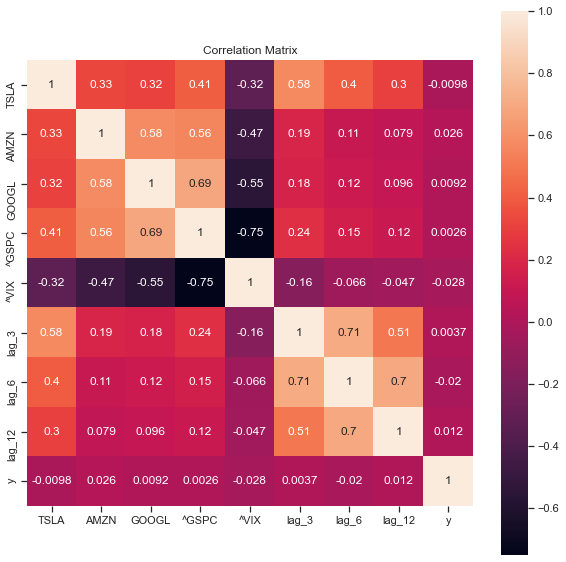

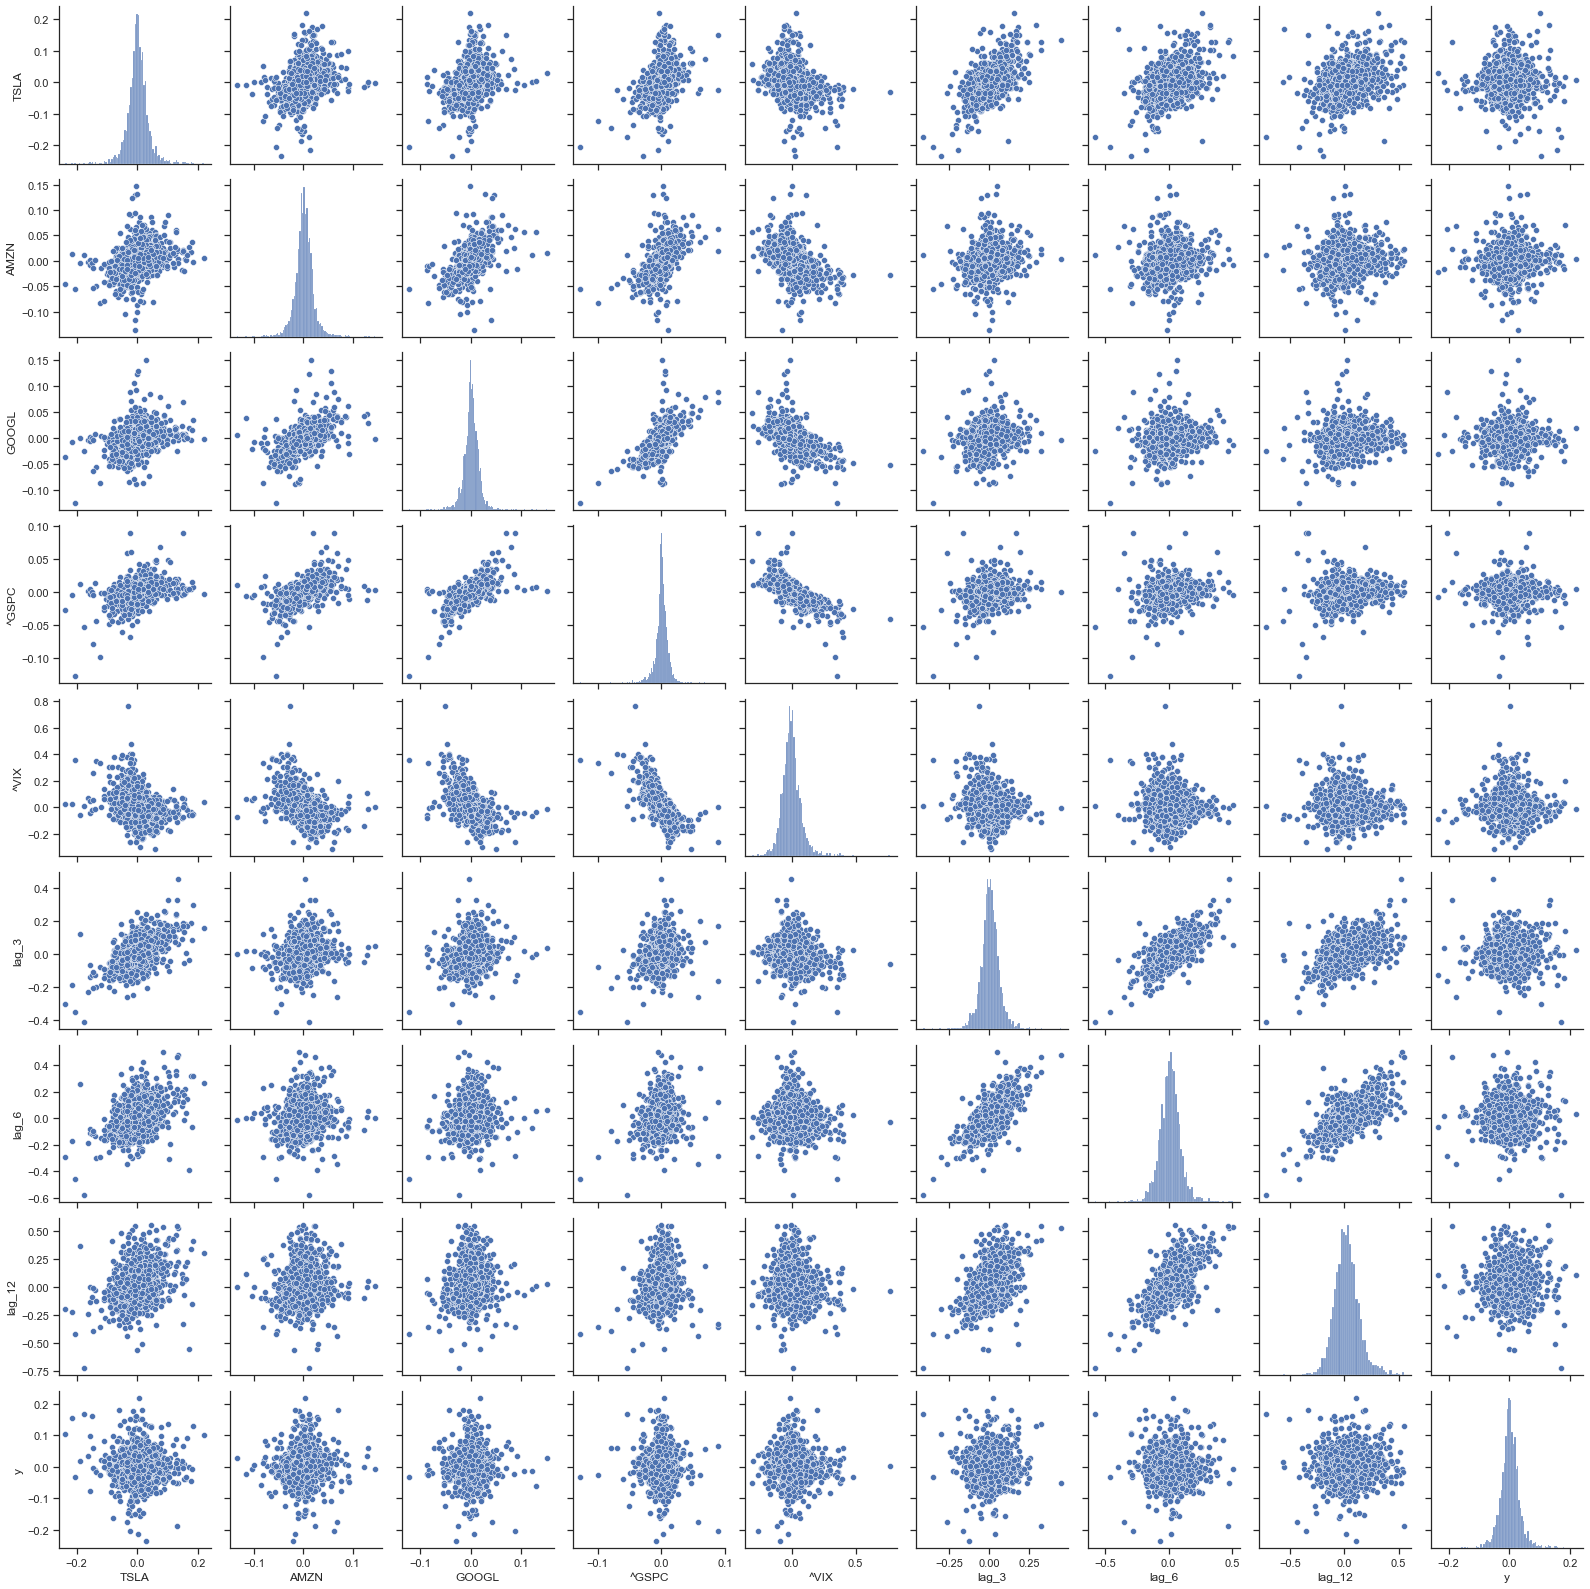

In [166]:
correlation = r_dataset.corr()
correlation
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True)
sns.pairplot(r_dataset)
plt.show()

## Get train data and test data

In [167]:
#Split data
x = r_dataset.iloc[:,:-1]
y = r_dataset["y"]
size_test_data = 0.2
size_train_data = int(len(r_dataset) * (1-size_test_data))
x_train, x_test = x[0:size_train_data], x[size_train_data:len(x)]
y_train, y_test = y[0:size_train_data], y[size_train_data:len(y)]

## Regression models 

In [168]:
#Import libraries to fit regression models
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

LR = LinearRegression()
KNN = KNeighborsRegressor()
CART= DecisionTreeRegressor()
SVR = SVR()
MLP = MLPRegressor()
ABR = AdaBoostRegressor()
GBR = GradientBoostingRegressor()
RFR = RandomForestRegressor()
ETR = ExtraTreesRegressor()
models = [LR,KNN,CART,SVR,MLP,ABR,GBR,RFR,ETR]
names = ['Linear Regression','K Nearest Neighbors','Decision Tree','Support Vector Machines','Multilayer Perceptron','Ada Boosting','Gradient Boosting','Random Forest','Extra trees']
simbol = ['LR','KNN','CART','SVR','MLP','ABR','GBR','RFR','ETR']

## Fit and MSE


In [169]:
test_results = []
train_results = []

for model in models:
    #Fit 
    fit = model.fit(x_train, y_train)
    #MSE
    test_result = mean_squared_error(fit.predict(x_test),y_test)
    test_results.append(test_result)

results = pd.DataFrame(names)
results.columns = ['model']  
results['test_error'] = test_results
results['simbol'] = ticks

i_best_model = test_results.index(min(test_results))

print('Best model: ' + results['model'][i_best_model])
print(results.iloc[:,:-1])

Best model: Multilayer Perceptron
                     model  test_error
0        Linear Regression    0.002149
1      K Nearest Neighbors    0.002366
2            Decision Tree    0.003703
3  Support Vector Machines    0.002939
4    Multilayer Perceptron    0.002146
5             Ada Boosting    0.002180
6        Gradient Boosting    0.002203
7            Random Forest    0.002235
8              Extra trees    0.002172


## MSE 

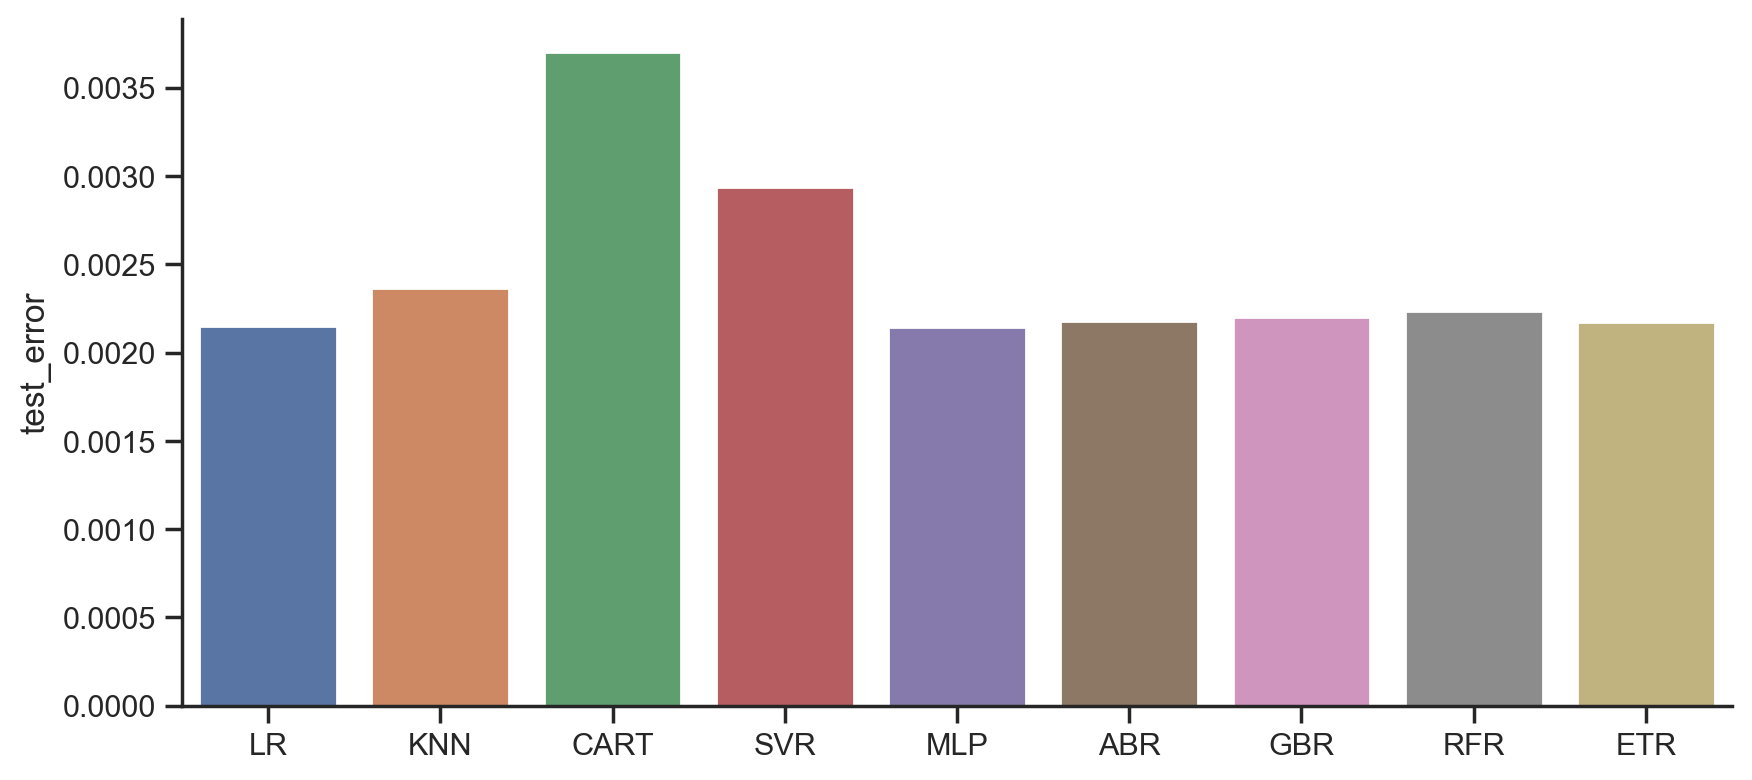

In [170]:
plt.figure(figsize=(10, 10), dpi = 200)
#test error
plt.subplot(2,1,2)
sns.despine()
sns.barplot(x='simbol', y="test_error" ,data=results)
plt.xlabel('')

plt.show()
plt.close()

## Best Model Prediction 

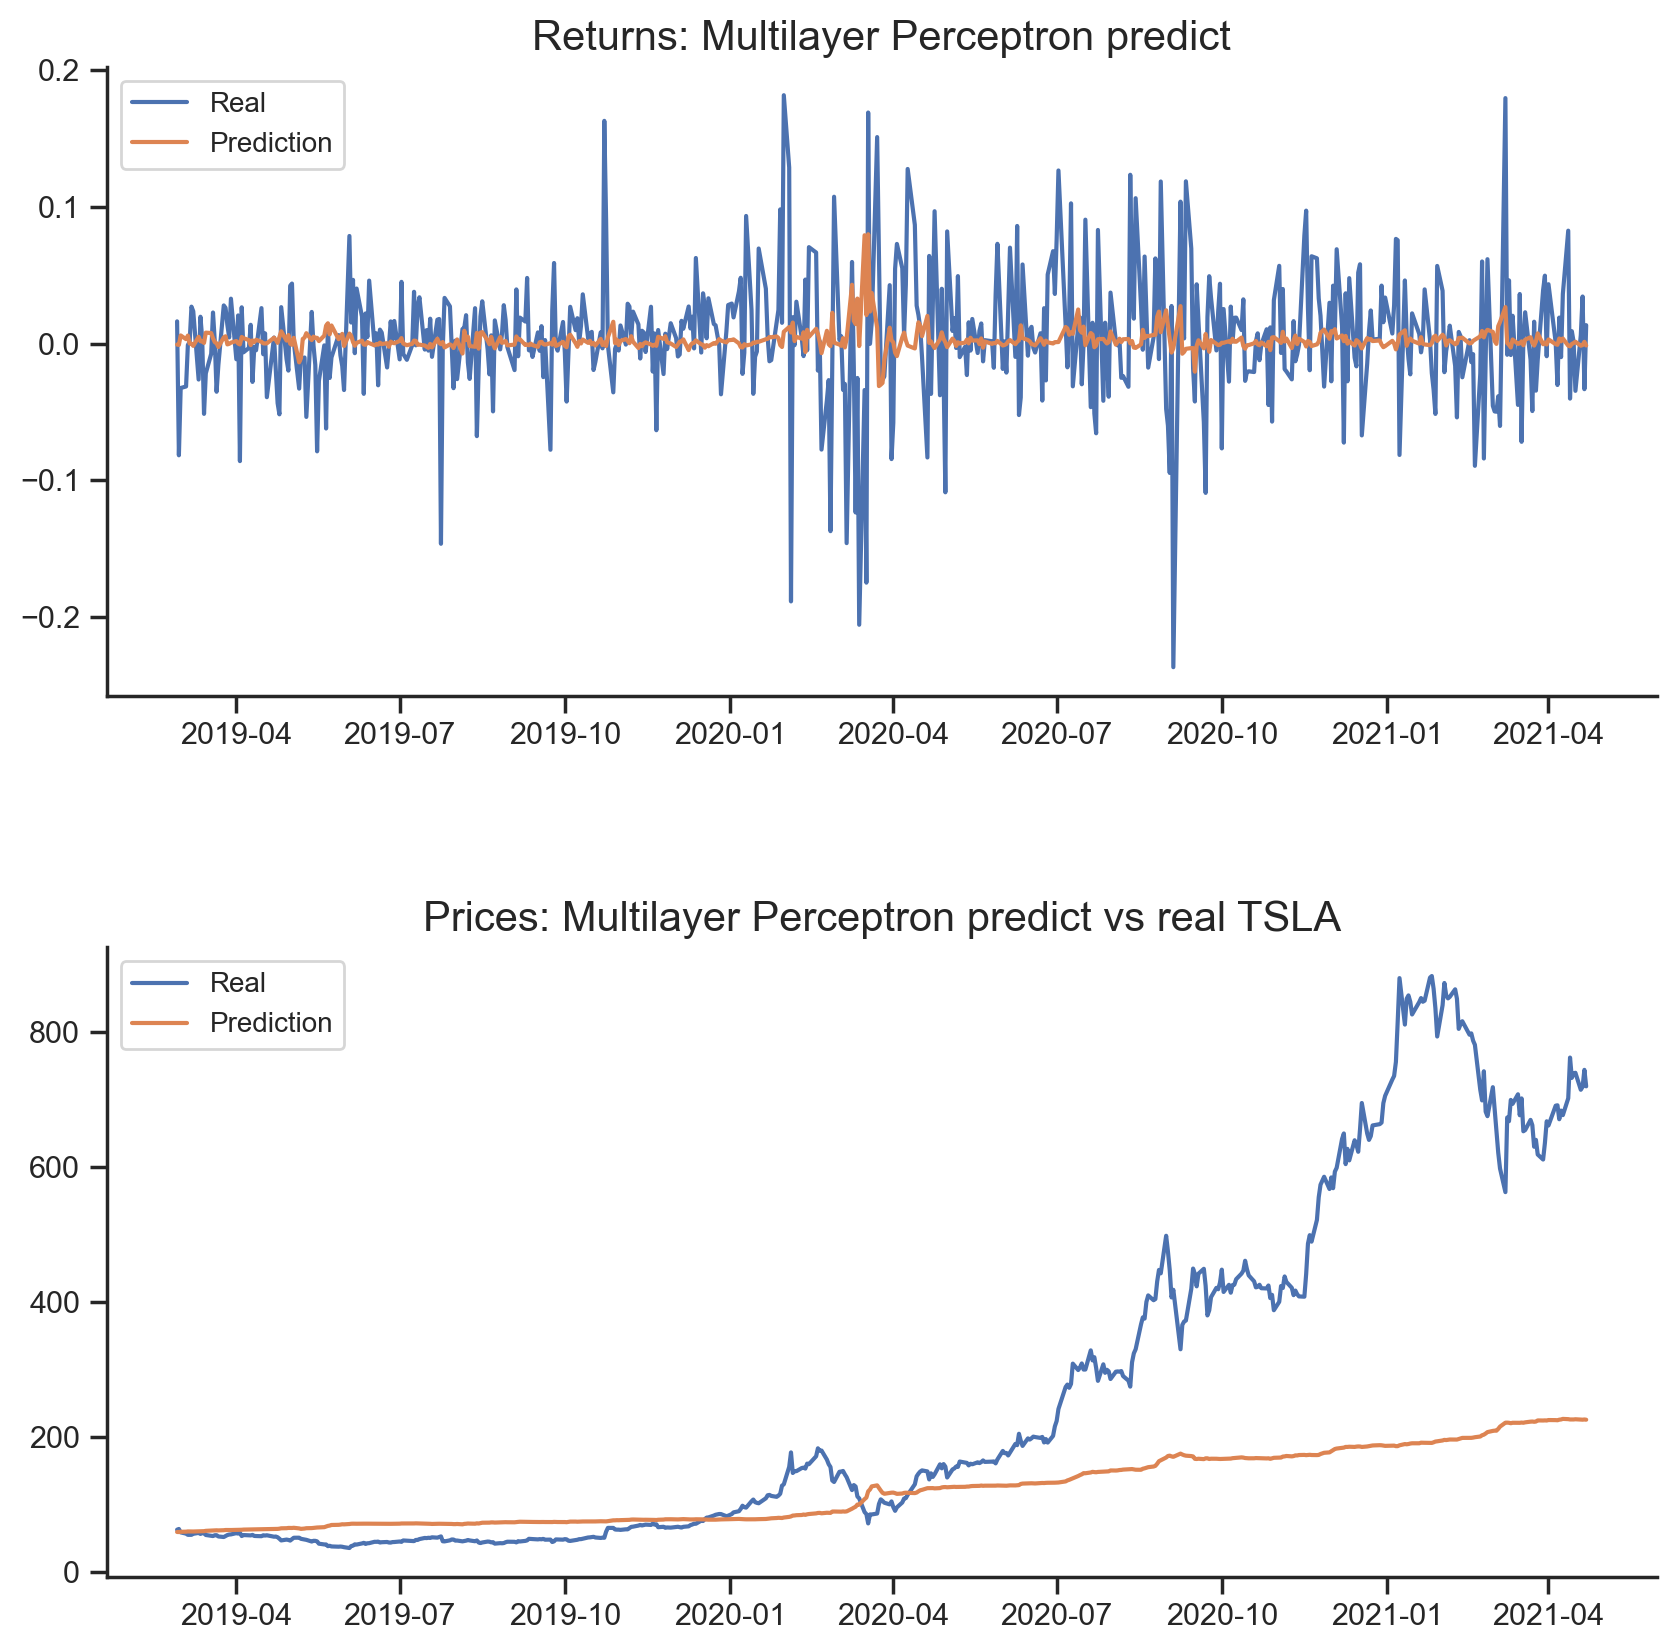

In [171]:
#Prediction
r_predict_best_model = pd.Series(models[i_best_model].predict(x_test))
r_predict_best_model.index = y_test.index
p_serie = dataset[serie]
p_serie_train = p_serie.loc[y_train.index]
p_serie_test = p_serie.loc[y_test.index]
p_0 = p_serie_train[-1]
p_predict_best_model =  p_0*np.exp(r_predict_best_model).cumprod()

#Figure size
plt.figure(figsize=(10, 10), dpi = 200)

#Plot returns prediction
plt.subplot(2,1,1)
plt.title( 'Returns: '+ results.model[i_best_model] + ' predict',fontsize = 15)
sns.despine()
sns.lineplot(y_test.index,y_test)
sns.lineplot(r_predict_best_model.index,r_predict_best_model)
plt.legend(['Real','Prediction'],fontsize = 10)
plt.ylabel('')
plt.xlabel('')

#Plot price prediction
plt.subplot(2,1,2)
plt.title( 'Prices: '+ results.model[i_best_model] + ' predict vs real ' + serie,fontsize = 15)
sns.despine()
sns.lineplot(p_serie_test.index,p_serie_test)
sns.lineplot(p_serie_test.index,p_predict_best_model)
plt.legend(['Real','Prediction'],fontsize = 10)
plt.ylabel('')
plt.xlabel('')


plt.subplots_adjust(hspace=0.40)
 
plt.show()
plt.close()


